# Graph and Visualize Wildfire Evacuation Experiment Results

This notebook is used to collate data from experiments and create the figures used in the forthcoming manuscript, "Evaluating Routing Strategies for Emergency Evacuation: A Spatially Explicit Agent-Based Modeling Approach" by Rebecca Vandewalle, Furqan Baig, Santiago Nunez-Corrales, Jeon Young Kang, and Shaowen Wang.

See the [FireABM_Demo_Notebook](./FireABM_Demo_Notebook.ipynb) for more information on the code needed to create the simulation results that are used in this notebook.

Notebook author: Rebecca Vandewalle
<br>Last updated: 1-4-24

<a id='top'></a>
## Table of Contents
- [Initial setup](#setup)
- [Initial data collection and formatting](#data_coll_format)
- [Create kernel density maps](#create_kernel_maps)
- [Assess clearance times](#assess_clearance)
- [Graph clearance times](#graph_clearance)
- [Graph clearance difference chart](#graph_clearance_difference)
- [Graph congestion chart](#graph_congestion)
- [Graph congestion difference chart](#graph_congestion_difference)

<a id='setup'></a>
## Initial setup
([back to Table of Contents](#top))

These cells load the required libraries to run the code. `%matplotlib inline` is a flag to display plots inline and the next cell imports required libraries.

In [1]:
%matplotlib inline

In [2]:
# Import packages and functions
# Use Python kernel 3-0.9.4

import os
import glob
import csv
import json
import numpy
import statistics
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation, artist
from scipy import stats
from FireABM_opt import *


In [3]:
# install CV2 - uncomment to install
#!pip3 install opencv-python

In [4]:
# check versions of important packages
import osmnx as ox
print (ox.__version__) # expected version 1.2.2
import networkx as nx
print (nx.__version__) # expected version 3.1
import cv2
print (cv2.__version__)  # expected version 4.8.1

1.0.1
2.5.1
4.9.0


### Set output folder and input file name here

Note: for space reasons, one combined results file may not be provided. If that is the case, run `combine_results.py` to combine `dist_results.txt`, `mjrd_results.txt`, and `quik_results.txt` into one file for processing, and adjust the input file name (`in_fn`) in the next cell.

In [5]:
# Set input file and output folder names

out_folder = 'out_figures_demo'
in_fn = 'combined_rslts_8_13.txt'  # rename if needed to combined output file


Next create an output folder if one doesn't already exist.

In [6]:
# Create output folder

if not os.path.isdir(out_folder):
    os.mkdir(out_folder)


### View road graph and attributes

This section is used to visualize the base attributes that are used by the simulation. This is helpful for debugging and getting a sense of how the study area road network is set up.

First the road graph is loaded from a pickle file, which is a way that objects are serialized and deserialized in Python. After the graph is loaded, a new road graph object is created. Then geodatabase files (.gdf) are created from the road network for convienence, as it is easier to work with these files for some aspects of inspecting the road network data. Bounding boxes in a few different formates are constructed using the `create_bboxes` function. This automatically sets the bounding box (which determines the evacuation zone) as a rectangle at a certain distance from each side of the study area (set by `buff_adj`.

In [7]:
# Load road graph

road_graph_pkl = 'Sta_Rosa_8000.pkl'
road_graph = load_road_graph(road_graph_pkl)
gdf_nodes, gdf_edges = get_node_edge_gdf(road_graph)
(bbox, lbbox, poly, x, y) = create_bboxes(gdf_nodes, 0.1,
                                          buff_adj=[2.1, 4.5, 3, 3])

# Add centroid data (used for kernel density)
for e in road_graph.edges(keys=True, data=True):
    if 'geometry' in e[3]:
        e[3]['cntrd_x'] = e[3]['geometry'].centroid.x
        e[3]['cntrd_y'] = e[3]['geometry'].centroid.y


This line loads the fire data from a shapefile. It sets the initial time for the fire at the time stamp of 60, this is so it starts slightly bigger and will more quickly impact evacuation traffic.

In [8]:
# Load fire for initial map

sr_fire = load_shpfile(road_graph, ("fire_input", 'santa_rosa_fire.shp'))
init_fire = sr_fire[sr_fire['SimTime'] == 60]


This bit of code displays an overview of the model input: the road network, the bounding box that defines the evacuation zone, and finally the initial fire location.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


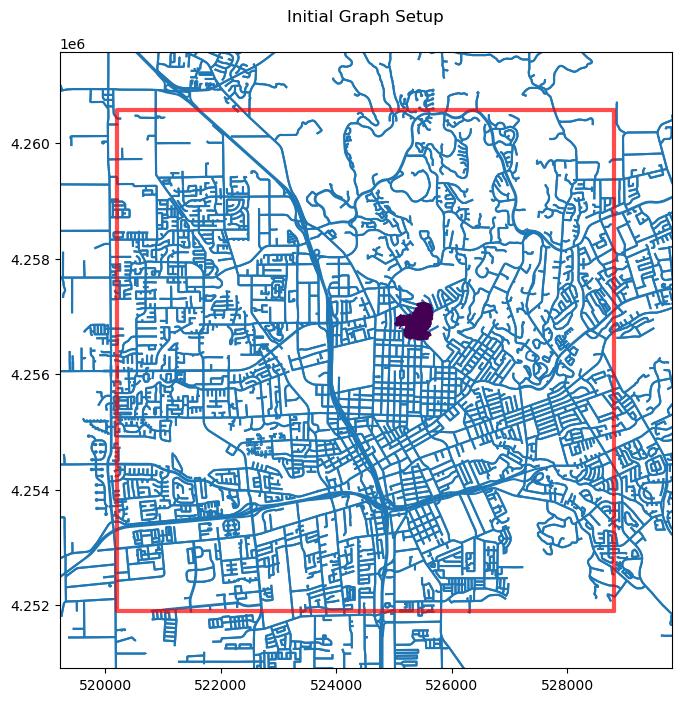

In [9]:
# Save initial setup graph

fig, ax = check_graphs(gdf_edges, x=x, y=y, shpfile=init_fire)
ax.set_xlim(min(x)-1000, max(x)+1000)
ax.set_ylim(min(y)-1000, max(y)+1000)
title = ax.text(0.5, 1.05, "Initial Graph Setup",
                size=plt.rcParams["axes.titlesize"],
                ha="center", transform=ax.transAxes)
plt.savefig(os.path.join(out_folder, 'initial graph configuration.eps'), format='eps')


This shows the projection information used by the road network.

In [10]:
# show road graph info
road_graph.graph['crs']


<Derived Projected CRS: +proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

The next two cells display some of the key road network attributes that are used in the simulation. This first graph shows the weight given to road segments (which is determined by the road type).

Attribute: rt_weight, Type: int64


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


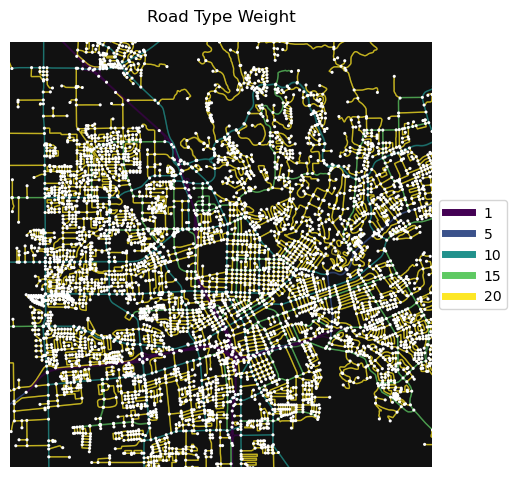

In [11]:
# view major roads (road weights)

fig, ax = view_edge_attrib(road_graph, 'rt_weight',
                           show_val=True, val=[1, 5, 10, 15, 20])
ax.set_xlim(min(x)-1000, max(x)+1000)
ax.set_ylim(min(y)-1000, max(y)+1000)
title = ax.text(0.5, 1.05, "Road Type Weight",
                size=plt.rcParams["axes.titlesize"],
                ha="center", transform=ax.transAxes)
plt.savefig(os.path.join(out_folder, 'initial graph roads weights.eps'),  format='eps');


This graph shows the speed limit of road segments in the road network.

Attribute: speed, Type: float64
min 2.24 max 29.06


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


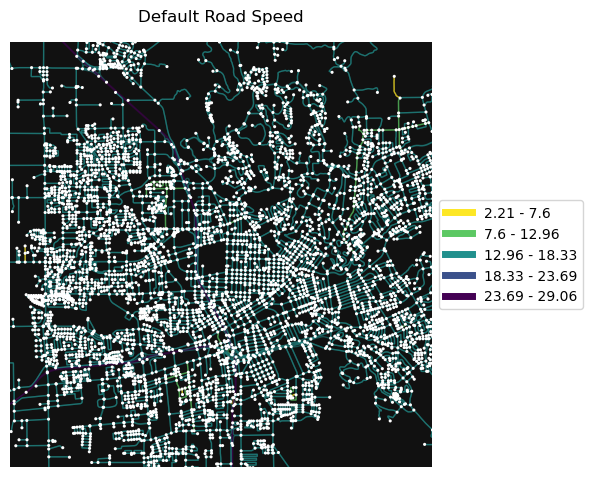

In [12]:
# view speed

fig, ax = view_edge_attrib(road_graph, 'speed', num_bins=5,  cmap='viridis_r')
ax.set_xlim(min(x)-1000, max(x)+1000)
ax.set_ylim(min(y)-1000, max(y)+1000)
title = ax.text(0.5, 1.05, "Default Road Speed",
                size=plt.rcParams["axes.titlesize"],
                ha="center", transform=ax.transAxes)
plt.savefig(os.path.join(out_folder, 'initial graph speeds.eps'), format='eps');


Finally, these are the fields used in the output file structure.

In [13]:
# Define data fieldnames

fieldnames = ['Exp_no', 'NB_no',
              'Treat_no', 'Rep_no', 'Seed',
              'Elpsd_time_TS',
              'Total_cars', 'Stuck_cars',
              'Num_rds_in_bbox',
              'veh_by_strat',
              'Finish_time',
              'Treat_desc', 'Exp_desc', 'RG_file',
              'Veh_stat_by_time',
              'Cong_by_time',
              'Veh_by_edge',
              'Init_Veh_coords']


### Check for sucessful and bad seeds

The random seed is used for the initial placement of vehicles on the road graph. Not every simulation pass is able to complete sucessfully. For this reason, only simulations for seeds that are sucessfull in each test case are kept so that the comparison is between simulations with the same sets of starting configurations. This code iterates through the results and finds which seeds produced successful runs for each of the treatment conditions. It sorts out seeds that failed for at least one of the treatments; these seeds are not used. The initial simulations are run with more seeds than the experiment calls for so that there should be enough valid runs after runs with bad seeds are removed.

In [14]:
# Read input data, isolate bad seeds
# Bad seeds are seeds that did not successfully
# run for all three driving strategies

seed_dict = {}
bad_seeds_fp = set()

with open(in_fn, 'r') as input_csvfile:
    reader = csv.DictReader(input_csvfile, delimiter='\t')
    for row in reader:
        strat = row['veh_by_strat'].split("'")[1]
        seed = int(row['Seed'])
        if seed_dict.get(strat):
            seed_dict[strat].append(seed)
        else:
            seed_dict[strat] = [seed]

all_strats = list(seed_dict.keys())

for dstrat in all_strats:
    print(dstrat+':', len(set(seed_dict[dstrat])), 'seeds')

common_seeds = None
for di in range(len(all_strats)-1):
    if common_seeds is None:
        common_seeds = set(seed_dict[all_strats[di]]) & set(seed_dict[all_strats[di+1]])
    else:
        common_seeds = common_seeds & set(seed_dict[all_strats[di+1]])

for dstrat in all_strats:
    print(set(seed_dict[dstrat]) - common_seeds)
    bad_seeds_fp.update((set(seed_dict[dstrat]) - common_seeds))

for dstrat in all_strats:
    print(dstrat, len(seed_dict[dstrat]))
    print(sorted(list(seed_dict[dstrat])))

print('common seed len:', len(common_seeds))
# print('common seeds:')
# print(common_seeds)
print('bad seed len:', len(bad_seeds_fp))
print('bad seeds:')
print(sorted(list(bad_seeds_fp)))
print('cutoff for 100 seeds:', sorted(common_seeds)[99])

cutoff_seed = int(sorted(common_seeds)[99])


dist+road_type_weight: 115 seeds
quickest: 113 seeds
dist: 121 seeds
{35, 104, 113, 55, 60, 29}
{40, 107, 83, 20}
{35, 40, 104, 107, 113, 83, 20, 55, 120, 90, 60, 29}
dist+road_type_weight 115
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]
quickest 113
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 8

<a id='data_coll_format'></a>
## Initial data collection and formatting
([back to Table of Contents](#top))

This section contains code that sets up derived varibles and stores the results in a series of lists for better display.

### Calculate clearance times, initial congestion

This section sorts out output data into a series of paired arrays to use for graphing the data.

In [15]:
# Calculate clearance times, congestion

# seed dictionaries
bad_seeds = list(bad_seeds_fp)
dist_seeds = []
majr_seeds = []
quik_seeds = []

# total clearance time
tot_clear_times = {'dist': [], 'majr': [], 'quik': []}
tot_clear_times_seed = {'dist': {}, 'majr': {}, 'quik': {}}

# clearance by time dictionaries (for clearance by time graph)
time_clear_lst_dist = [[], []]
time_clear_lst_majr = [[], []]
time_clear_lst_quik = [[], []]
time_clear_aver_dist = {}
time_clear_aver_majr = {}
time_clear_aver_quik = {}
time_clear_lst_m_std_dist = [[], [], []]
time_clear_lst_m_std_majr = [[], [], []]
time_clear_lst_m_std_quik = [[], [], []]

# congestion by time dictionaries (for congestion by time graph)
time_cong_lst_dist = [[], []]
time_cong_lst_majr = [[], []]
time_cong_lst_quik = [[], []]
time_cong_aver_dist = {}
time_cong_aver_majr = {}
time_cong_aver_quik = {}
time_cong_lst_m_std_dist = [[], [], []]
time_cong_lst_m_std_majr = [[], [], []]
time_cong_lst_m_std_quik = [[], [], []]

# congestion by edge dictionary (for congestion by time maps)
edge_cong_dict_dist = {}
edge_cong_dict_majr = {}
edge_cong_dict_quik = {}

row_count = 0
valid_row_count = 0
with open(in_fn, 'r') as in_csvfile:
    reader = csv.DictReader(in_csvfile, delimiter='\t')
    for row in reader:
        row_count = row_count + 1
        # if row_count >10:
        #    break
        if int(row['Seed']) in bad_seeds:
            # print(row_count, 'sd:', row['Seed'], '=bad seed')
            continue
        # ran more than needed as some failed, cut off after 100 valid seeds
        if int(row['Seed']) > cutoff_seed:
            continue

        # print(row_count, 'sd:', row['Seed'], '=not bad seed')

        strat = row['veh_by_strat'].split("'")[1]
        time_clear = json.loads(row['Veh_stat_by_time'].replace("'", '"'))
        time_cong = json.loads(row['Cong_by_time'].replace("'", '"'))

        edge_cong = json.loads(row['Veh_by_edge'].replace("'", '"'))

        if strat == 'dist':
            if int(row['Seed']) in dist_seeds:
                # print('dist', row_count, 'sd:', row['Seed'],
                # 'seed already counted')
                pass
            else:
                # print('dist sd:', row['Seed'], type(row['Seed']))
                dist_seeds.append(int(row['Seed']))
                valid_row_count = valid_row_count + 1

                tot_clear_times['dist'].append(int(row['Elpsd_time_TS']))
                tot_clear_times_seed['dist'][row['Seed']] = int(
                    row['Elpsd_time_TS'])
                # clearance by time dictionaries
                for tcv in time_clear:
                    time_clear_lst_dist[0].append(tcv['ts'])
                    time_clear_lst_dist[1].append(tcv['pctclear'])
                    if tcv['ts'] in time_clear_aver_dist.keys():
                        time_clear_aver_dist[tcv['ts']].append(tcv['pctclear'])
                    else:
                        time_clear_aver_dist[tcv['ts']] = [tcv['pctclear']]

                # congestion by time dictionaries
                for tcgv in time_cong:
                    time_cong_lst_dist[0].append(tcgv['ts'])
                    time_cong_lst_dist[1].append(tcgv['ave_veh_p_rd'])

                    if tcgv['ts'] in time_cong_aver_dist.keys():
                        time_cong_aver_dist[tcgv['ts']].append(
                            tcgv['ave_veh_p_rd'])
                    else:
                        time_cong_aver_dist[tcgv['ts']] = [
                            tcgv['ave_veh_p_rd']]

            # congestion by edge edge_cong_dict_dist numv
                for edge_key in edge_cong.keys():
                    ec_ts = edge_cong[edge_key][0]['ts']
                    ec_numv = edge_cong[edge_key][0]['numv']
                    if ec_ts in edge_cong_dict_dist.keys():
                        if edge_key in edge_cong_dict_dist[ec_ts].keys():
                            (edge_cong_dict_dist[ec_ts][edge_key]['numv_list'].append(ec_numv))
                        else:
                            edge_cong_dict_dist[ec_ts][edge_key] = {}
                            edge_cong_dict_dist[ec_ts][edge_key]['numv_list'] = [ec_numv]
                    else:
                        edge_cong_dict_dist[ec_ts] = {}
                        edge_cong_dict_dist[ec_ts][edge_key] = {}
                        edge_cong_dict_dist[ec_ts][edge_key]['numv_list'] = [ec_numv]

        elif strat == 'dist+road_type_weight':
            if int(row['Seed']) in majr_seeds:
                # print('majr', row_count, 'sd:', row['Seed'], 'seed already counted')
                pass
            else:
                # print('major sd:', row['Seed'], type(row['Seed']))
                majr_seeds.append(int(row['Seed']))
                valid_row_count = valid_row_count + 1

                tot_clear_times['majr'].append(int(row['Elpsd_time_TS']))
                tot_clear_times_seed['majr'][row['Seed']] = int(row['Elpsd_time_TS'])
                # clearance by time dictionaries
                for tcv in time_clear:
                    time_clear_lst_majr[0].append(tcv['ts'])
                    time_clear_lst_majr[1].append(tcv['pctclear'])
                    if tcv['ts'] in time_clear_aver_majr.keys():
                        time_clear_aver_majr[tcv['ts']].append(tcv['pctclear'])
                    else:
                        time_clear_aver_majr[tcv['ts']] = [tcv['pctclear']]

                # congestion by time dictionaries
                for tcgv in time_cong:
                    time_cong_lst_majr[0].append(tcgv['ts'])
                    time_cong_lst_majr[1].append(tcgv['ave_veh_p_rd'])

                    if tcgv['ts'] in time_cong_aver_majr.keys():
                        time_cong_aver_majr[tcgv['ts']].append(tcgv['ave_veh_p_rd'])
                    else:
                        time_cong_aver_majr[tcgv['ts']] = [tcgv['ave_veh_p_rd']]

            # congestion by edge  edge_cong_dict_majr
                for edge_key in edge_cong.keys():
                    ec_ts = edge_cong[edge_key][0]['ts']
                    ec_numv = edge_cong[edge_key][0]['numv']
                    if ec_ts in edge_cong_dict_majr.keys():
                        if edge_key in edge_cong_dict_majr[ec_ts].keys():
                            edge_cong_dict_majr[ec_ts][edge_key]['numv_list'].append(ec_numv)
                        else:
                            edge_cong_dict_majr[ec_ts][edge_key] = {}
                            edge_cong_dict_majr[ec_ts][edge_key]['numv_list'] = [ec_numv]
                    else:
                        edge_cong_dict_majr[ec_ts] = {}
                        edge_cong_dict_majr[ec_ts][edge_key] = {}
                        edge_cong_dict_majr[ec_ts][edge_key]['numv_list'] = [ec_numv]

        elif strat == 'quickest':
            if int(row['Seed']) in quik_seeds:
                # print('majr', row_count, 'sd:', row['Seed'], 'seed already counted')
                pass
            else:
                # print('quick sd:', row['Seed'], type(row['Seed']))
                quik_seeds.append(int(row['Seed']))
                valid_row_count = valid_row_count + 1

                tot_clear_times['quik'].append(int(row['Elpsd_time_TS']))
                tot_clear_times_seed['quik'][row['Seed']] = int(row['Elpsd_time_TS'])
                # clearance by time dictionaries
                for tcv in time_clear:
                    time_clear_lst_quik[0].append(tcv['ts'])
                    time_clear_lst_quik[1].append(tcv['pctclear'])
                    if tcv['ts'] in time_clear_aver_quik.keys():
                        time_clear_aver_quik[tcv['ts']].append(tcv['pctclear'])
                    else:
                        time_clear_aver_quik[tcv['ts']] = [tcv['pctclear']]

                # congestion by time dictionaries
                for tcgv in time_cong:
                    time_cong_lst_quik[0].append(tcgv['ts'])
                    time_cong_lst_quik[1].append(tcgv['ave_veh_p_rd'])

                    if tcgv['ts'] in time_cong_aver_quik.keys():
                        time_cong_aver_quik[tcgv['ts']].append(tcgv['ave_veh_p_rd'])
                    else:
                        time_cong_aver_quik[tcgv['ts']] = [tcgv['ave_veh_p_rd']]

            # congestion by edge  edge_cong_dict_majr
                for edge_key in edge_cong.keys():
                    ec_ts = edge_cong[edge_key][0]['ts']
                    ec_numv = edge_cong[edge_key][0]['numv']
                    if ec_ts in edge_cong_dict_quik.keys():
                        if edge_key in edge_cong_dict_quik[ec_ts].keys():
                            edge_cong_dict_quik[ec_ts][edge_key]['numv_list'].append(ec_numv)
                        else:
                            edge_cong_dict_quik[ec_ts][edge_key] = {}
                            edge_cong_dict_quik[ec_ts][edge_key]['numv_list'] = [ec_numv]
                    else:
                        edge_cong_dict_quik[ec_ts] = {}
                        edge_cong_dict_quik[ec_ts][edge_key] = {}
                        edge_cong_dict_quik[ec_ts][edge_key]['numv_list'] = [ec_numv]

# clearance by time dictionaries (for clearance graph)
for key in time_clear_aver_dist.keys():
    time_clear_lst_m_std_dist[0].append(key)
    time_clear_lst_m_std_dist[1].append(
        sum(time_clear_aver_dist[key])/len(time_clear_aver_dist[key]))
    if len(time_clear_aver_dist[key]) > 1:
        time_clear_lst_m_std_dist[2].append(
            statistics.stdev(time_clear_aver_dist[key]))
    else:
        time_clear_lst_m_std_dist[2].append(0)

for key in time_clear_aver_majr.keys():
    time_clear_lst_m_std_majr[0].append(key)
    time_clear_lst_m_std_majr[1].append(
        sum(time_clear_aver_majr[key])/len(time_clear_aver_majr[key]))
    if len(time_clear_aver_majr[key]) > 1:
        time_clear_lst_m_std_majr[2].append(
            statistics.stdev(time_clear_aver_majr[key]))
    else:
        time_clear_lst_m_std_majr[2].append(0)

for key in time_clear_aver_quik.keys():
    time_clear_lst_m_std_quik[0].append(key)
    time_clear_lst_m_std_quik[1].append(
        sum(time_clear_aver_quik[key])/len(time_clear_aver_quik[key]))
    if len(time_clear_aver_quik[key]) > 1:
        time_clear_lst_m_std_quik[2].append(
            statistics.stdev(time_clear_aver_quik[key]))
    else:
        time_clear_lst_m_std_quik[2].append(0)

# congestion by time dictionaries (for congestion by time graph)
for key in time_cong_aver_dist.keys():
    time_cong_lst_m_std_dist[0].append(key)
    time_cong_lst_m_std_dist[1].append(
        sum(time_cong_aver_dist[key])/len(time_cong_aver_dist[key]))
    if len(time_cong_aver_dist[key]) > 1:
        time_cong_lst_m_std_dist[2].append(
            statistics.stdev(time_cong_aver_dist[key]))
    else:
        time_cong_lst_m_std_dist[2].append(0)

for key in time_cong_aver_majr.keys():
    time_cong_lst_m_std_majr[0].append(key)
    time_cong_lst_m_std_majr[1].append(
        sum(time_cong_aver_majr[key])/len(time_cong_aver_majr[key]))
    if len(time_cong_aver_majr[key]) > 1:
        time_cong_lst_m_std_majr[2].append(
            statistics.stdev(time_cong_aver_majr[key]))
    else:
        time_cong_lst_m_std_majr[2].append(0)

for key in time_cong_aver_quik.keys():
    time_cong_lst_m_std_quik[0].append(key)
    time_cong_lst_m_std_quik[1].append(
        sum(time_cong_aver_quik[key])/len(time_cong_aver_quik[key]))
    if len(time_cong_aver_quik[key]) > 1:
        time_cong_lst_m_std_quik[2].append(
            statistics.stdev(time_cong_aver_quik[key]))
    else:
        time_cong_lst_m_std_quik[2].append(0)


# Congestion by edge by time dictionaries
for time_key in edge_cong_dict_dist.keys():
    for edge_key in edge_cong_dict_dist[time_key]:
        edge_cong_dict_dist[time_key][edge_key]['ave_veh'] = round(
            sum(edge_cong_dict_dist[time_key][edge_key]['numv_list'])/len(
                edge_cong_dict_dist[time_key][edge_key]['numv_list']), 2)

for time_key in edge_cong_dict_majr.keys():
    for edge_key in edge_cong_dict_majr[time_key]:
        edge_cong_dict_majr[time_key][edge_key]['ave_veh'] = round(
            sum(edge_cong_dict_majr[time_key][edge_key]['numv_list'])/len(
                edge_cong_dict_majr[time_key][edge_key]['numv_list']), 2)

for time_key in edge_cong_dict_quik.keys():
    for edge_key in edge_cong_dict_quik[time_key]:
        edge_cong_dict_quik[time_key][edge_key]['ave_veh'] = round(
            sum(edge_cong_dict_quik[time_key][edge_key]['numv_list'])/len(
                edge_cong_dict_quik[time_key][edge_key]['numv_list']), 2)

print('total rows seen:', row_count)
print('valid rows seen:', valid_row_count)
print('numb dist', len(dist_seeds))
print('numb majr', len(majr_seeds))
print('numb quik', len(quik_seeds))


total rows seen: 349
valid rows seen: 300
numb dist 100
numb majr 100
numb quik 100


### Format congestion for time chart

This section calculates edge congestion from the output data to use for the congestion chart.

In [16]:
# Create congestion map time chart setup

new_run = True
if new_run:
    for time_key in edge_cong_dict_dist.keys():
        d_edge_cong_timekey_dict = {}
        col_name = 'd_t'+str(time_key)+'_ave_veh'
        col_name_ln = 'd_t'+str(time_key)+'_aveh_plngth'
        for edge_key in edge_cong_dict_dist[time_key]:
            d_edge_cong_timekey_dict[eval(edge_key)] = edge_cong_dict_dist[time_key][edge_key]['ave_veh']
        nx.set_edge_attributes(road_graph, d_edge_cong_timekey_dict, col_name)
        #print(set(d_edge_cong_timekey_dict.values())
        for e in road_graph.edges(keys=True, data=True):
            if col_name not in e[3]:
                e[3][col_name] = 0.0
            e[3][col_name_ln] = e[3][col_name]/e[3]['length']
                
    for time_key in edge_cong_dict_majr.keys():
        m_edge_cong_timekey_dict = {}
        col_name = 'm_t'+str(time_key)+'_ave_veh'
        col_name_ln = 'm_t'+str(time_key)+'_aveh_plngth'
        for edge_key in edge_cong_dict_majr[time_key]:
            m_edge_cong_timekey_dict[eval(edge_key)] = edge_cong_dict_majr[time_key][edge_key]['ave_veh']
        nx.set_edge_attributes(road_graph, m_edge_cong_timekey_dict, col_name)
        #print(set(m_edge_cong_timekey_dict.values()))
        for e in road_graph.edges(keys=True, data=True):
            if col_name not in e[3]:
                e[3][col_name] = 0.0
            e[3][col_name_ln] = e[3][col_name]/e[3]['length']
            
    for time_key in edge_cong_dict_quik.keys():
        m_edge_cong_timekey_dict = {}
        col_name = 'q_t'+str(time_key)+'_ave_veh'
        col_name_ln = 'q_t'+str(time_key)+'_aveh_plngth'
        for edge_key in edge_cong_dict_quik[time_key]:
            m_edge_cong_timekey_dict[eval(edge_key)] = edge_cong_dict_quik[time_key][edge_key]['ave_veh']
        nx.set_edge_attributes(road_graph, m_edge_cong_timekey_dict, col_name)
        #print(set(m_edge_cong_timekey_dict.values()))
        for e in road_graph.edges(keys=True, data=True):
            if col_name not in e[3]:
                e[3][col_name] = 0.0
            e[3][col_name_ln] = e[3][col_name]/e[3]['length']


This creates new geodatabase files with the updated data from the prior calculation.

In [17]:
# export new edge data

gdf_nodes, gdf_edges = get_node_edge_gdf(road_graph)


<a id='create_kernel_maps'></a>
## Create kernel density maps
([back to Table of Contents](#top))

Here a series of subfolders are created in order to store data.

In [18]:
# Make KDE Map folders

if not os.path.isdir(os.path.join(out_folder, 'dist_k_dens')):
    os.mkdir(os.path.join(out_folder, 'dist_k_dens'))
if not os.path.isdir(os.path.join(out_folder, 'majr_k_dens')):
    os.mkdir(os.path.join(out_folder, 'majr_k_dens'))
if not os.path.isdir(os.path.join(out_folder, 'quik_k_dens')):
    os.mkdir(os.path.join(out_folder, 'quik_k_dens'))
if not os.path.isdir(os.path.join(out_folder, 'k_dens_movies')):
    os.mkdir(os.path.join(out_folder, 'k_dens_movies'))


### Create kernel density maps per driving strategy
#### (normalized by driving strategy min and max)

The code in this section creates kernel density maps to display output.

In [19]:
# KDE Maps
# some source code from https://python-graph-gallery.com/86-avoid-overlapping-in-scatterplot-with-2d-density/

dist_art_frame = []
dist_times = sorted([time_key for time_key in edge_cong_dict_dist.keys()])
dist_k_dens = {}
dist_k_range = {'min':[], 'max':[]}

nbins = 50
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
ax.set_xlim(min(x)-1000, max(x)+1000)
ax.set_ylim(min(y)-1000, max(y)+1000)
edgelns = gdf_edges.plot(ax=ax, zorder=1, edgecolor='grey', alpha=1)
boundln, = ax.plot(x, y, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
xi, yi = np.mgrid[gdf_edges.cntrd_x.min():gdf_edges.cntrd_x.max():nbins*1j, gdf_edges.cntrd_y.min():gdf_edges.cntrd_y.max():nbins*1j]
    
for dist_time_key in dist_times:
    col_name = 'd_t'+str(dist_time_key)+'_ave_veh'
    k = stats.kde.gaussian_kde([gdf_edges.cntrd_x,gdf_edges.cntrd_y], weights=gdf_edges[col_name], bw_method=0.05)
    zi = k(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)
    dist_k_dens[dist_time_key] = zi
    dist_k_range['min'].append(zi.min())
    dist_k_range['max'].append(zi.max())
    
for dist_time_key in dist_times:
    zi = dist_k_dens[dist_time_key]
    kdens = ax.pcolormesh(xi, yi, zi, shading='gouraud', cmap=plt.cm.OrRd, 
                          vmin=min(dist_k_range['min']), 
                          vmax=sum(dist_k_range['max'])/len(dist_k_range['max']), 
                          alpha=0.75)
    title = ax.text(0.5,1.05,"Shortest Distance: Time {}".format(dist_time_key), 
                    size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax.transAxes, )
    dist_art_frame.append([kdens, title])
        
dist_ani = animation.ArtistAnimation(fig, dist_art_frame, interval=2000, blit=False)

plt.close()


/tmp/ipykernel_1041/3618240011.py:19: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = stats.kde.gaussian_kde([gdf_edges.cntrd_x,gdf_edges.cntrd_y], weights=gdf_edges[col_name], bw_method=0.05)


This saves the kernel density animated maps.

In [20]:
dist_ani.save(os.path.join(out_folder, 'k_dens_movies', 'dist_k_dens_html.mp4'))


This process is repeted for the other treatments.

In [21]:
# KDE Maps
# some source code from https://python-graph-gallery.com/86-avoid-overlapping-in-scatterplot-with-2d-density/

quik_art_frame = []
quik_times = sorted([time_key for time_key in edge_cong_dict_quik.keys()])
quik_k_dens = {}
quik_k_range = {'min':[], 'max':[]}

nbins = 50
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
ax.set_xlim(min(x)-1000, max(x)+1000)
ax.set_ylim(min(y)-1000, max(y)+1000)
edgelns = gdf_edges.plot(ax=ax, zorder=1, edgecolor='grey', alpha=1)
boundln, = ax.plot(x, y, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
xi, yi = np.mgrid[gdf_edges.cntrd_x.min():gdf_edges.cntrd_x.max():nbins*1j, gdf_edges.cntrd_y.min():gdf_edges.cntrd_y.max():nbins*1j]


for quik_time_key in quik_times:
    col_name = 'q_t'+str(quik_time_key)+'_ave_veh'
    k = stats.kde.gaussian_kde([gdf_edges.cntrd_x,gdf_edges.cntrd_y], weights=gdf_edges[col_name], bw_method=0.05)
    zi = k(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)
    quik_k_dens[quik_time_key] = zi
    quik_k_range['min'].append(zi.min())
    quik_k_range['max'].append(zi.max())
    
for quik_time_key in quik_times:  
    zi = quik_k_dens[quik_time_key]
    kdens = ax.pcolormesh(xi, yi, zi, shading='gouraud', cmap=plt.cm.OrRd, 
                          vmin=min(quik_k_range['min']), 
                          vmax=sum(quik_k_range['max'])/len(quik_k_range['max']), 
                          alpha=0.75)
    title = ax.text(0.5,1.05,"Quickest: Time {}".format(quik_time_key), 
                    size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax.transAxes, )
    quik_art_frame.append([kdens, title])
    
quik_ani = animation.ArtistAnimation(fig, quik_art_frame, interval=2000, blit=False)

plt.close()

/tmp/ipykernel_1041/2855416272.py:20: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = stats.kde.gaussian_kde([gdf_edges.cntrd_x,gdf_edges.cntrd_y], weights=gdf_edges[col_name], bw_method=0.05)


The kernel density animation is saved.

In [22]:
quik_ani.save(os.path.join(out_folder, 'k_dens_movies', 'quik_k_dens_html.mp4'))

This creates the kernel density map for the last treatment.

In [23]:
# KDE Maps
# some source code from https://python-graph-gallery.com/86-avoid-overlapping-in-scatterplot-with-2d-density/

majr_art_frame = []
majr_times = sorted([time_key for time_key in edge_cong_dict_majr.keys()])
majr_k_dens = {}
majr_k_range = {'min':[], 'max':[]}

nbins = 50
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
ax.set_xlim(min(x)-1000, max(x)+1000)
ax.set_ylim(min(y)-1000, max(y)+1000)
edgelns = gdf_edges.plot(ax=ax, zorder=1, edgecolor='grey', alpha=1)
boundln, = ax.plot(x, y, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
xi, yi = np.mgrid[gdf_edges.cntrd_x.min():gdf_edges.cntrd_x.max():nbins*1j, gdf_edges.cntrd_y.min():gdf_edges.cntrd_y.max():nbins*1j]

    
for majr_time_key in majr_times:
    col_name = 'm_t'+str(majr_time_key)+'_ave_veh'
    k = stats.kde.gaussian_kde([gdf_edges.cntrd_x,gdf_edges.cntrd_y], weights=gdf_edges[col_name], bw_method=0.05)
    zi = k(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)
    majr_k_dens[majr_time_key] = zi
    majr_k_range['min'].append(zi.min())
    majr_k_range['max'].append(zi.max())
    
for majr_time_key in majr_times:  
    zi = majr_k_dens[majr_time_key]
    kdens = ax.pcolormesh(xi, yi, zi, shading='gouraud', cmap=plt.cm.OrRd, 
                          vmin=min(majr_k_range['min']), 
                          vmax=sum(majr_k_range['max'])/len(majr_k_range['max']), 
                          alpha=0.75)
    title = ax.text(0.5,1.05,"Major Roads: Time {}".format(majr_time_key), 
                    size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax.transAxes, )
    majr_art_frame.append([kdens, title])

majrd_ani = animation.ArtistAnimation(fig, majr_art_frame, interval=2000, blit=False) 

plt.close()


/tmp/ipykernel_1041/3005887281.py:20: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = stats.kde.gaussian_kde([gdf_edges.cntrd_x,gdf_edges.cntrd_y], weights=gdf_edges[col_name], bw_method=0.05)


This saves the kernel density map from the last treatment.

In [24]:
majrd_ani.save(os.path.join(out_folder, 'k_dens_movies', 'mjrd_k_dens_html.mp4'))


### Create normalized kernel density maps 
#### (normalized by total min and max)

These cells work similarly to the prior section except this time it is normalized.

In [25]:
# Make KDE Map folders (normalized)

if not os.path.isdir(os.path.join(out_folder, 'dist_k_dens_norm')):
    os.mkdir(os.path.join(out_folder, 'dist_k_dens_norm'))
if not os.path.isdir(os.path.join(out_folder, 'majr_k_dens_norm')):
    os.mkdir(os.path.join(out_folder, 'majr_k_dens_norm'))
if not os.path.isdir(os.path.join(out_folder, 'quik_k_dens_norm')):
    os.mkdir(os.path.join(out_folder, 'quik_k_dens_norm'))
if not os.path.isdir(os.path.join(out_folder, 'k_dens_movies_norm')):
    os.mkdir(os.path.join(out_folder, 'k_dens_movies_norm'))


In [26]:
group_min = min(min(dist_k_range['min']), min(quik_k_range['min']), min(majr_k_range['min']))

maxes = list(dist_k_range['max'])
maxes.extend(quik_k_range['max'])
maxes.extend(majr_k_range['max'])

group_max = sum(maxes)/len(maxes)
group_max = statistics.median(maxes)


In [27]:
# KDE Maps
# some source code from https://python-graph-gallery.com/86-avoid-overlapping-in-scatterplot-with-2d-density/

dist_art_frame_norm = []

nbins = 50
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
ax.set_xlim(min(x)-1000, max(x)+1000)
ax.set_ylim(min(y)-1000, max(y)+1000)
edgelns = gdf_edges.plot(ax=ax, zorder=1, edgecolor='grey', alpha=1)
boundln, = ax.plot(x, y, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
xi, yi = np.mgrid[gdf_edges.cntrd_x.min():gdf_edges.cntrd_x.max():nbins*1j, gdf_edges.cntrd_y.min():gdf_edges.cntrd_y.max():nbins*1j]
        
for dist_time_key in dist_times:
    col_name = 'd_t'+str(dist_time_key)+'_ave_veh'
    k = stats.kde.gaussian_kde([gdf_edges.cntrd_x,gdf_edges.cntrd_y], weights=gdf_edges[col_name], bw_method=0.05)
    zi = k(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)
    kdens = ax.pcolormesh(xi, yi, zi, shading='gouraud', cmap=plt.cm.OrRd, 
                          vmin=group_min, 
                          vmax=group_max, 
                          alpha=0.75)
    title = ax.text(0.5,1.05,"Shortest Distance: Time {}".format(dist_time_key), 
                    size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax.transAxes, )
    dist_art_frame_norm.append([kdens, title])
        
dist_ani_norm = animation.ArtistAnimation(fig, dist_art_frame_norm, interval=2000, blit=False)

plt.close()


/tmp/ipykernel_1041/1764373935.py:16: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = stats.kde.gaussian_kde([gdf_edges.cntrd_x,gdf_edges.cntrd_y], weights=gdf_edges[col_name], bw_method=0.05)


In [28]:
dist_ani_norm.save(os.path.join(out_folder, 'k_dens_movies_norm', 'dist_k_dens_norm_html.mp4'))


In [29]:
# KDE Maps
# some source code from https://python-graph-gallery.com/86-avoid-overlapping-in-scatterplot-with-2d-density/

quik_art_frame_norm = []

nbins = 50
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
ax.set_xlim(min(x)-1000, max(x)+1000)
ax.set_ylim(min(y)-1000, max(y)+1000)
edgelns = gdf_edges.plot(ax=ax, zorder=1, edgecolor='grey', alpha=1)
boundln, = ax.plot(x, y, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
xi, yi = np.mgrid[gdf_edges.cntrd_x.min():gdf_edges.cntrd_x.max():nbins*1j, gdf_edges.cntrd_y.min():gdf_edges.cntrd_y.max():nbins*1j]

    
for quik_time_key in quik_times:  
    col_name = 'q_t'+str(quik_time_key)+'_ave_veh'
    k = stats.kde.gaussian_kde([gdf_edges.cntrd_x,gdf_edges.cntrd_y], weights=gdf_edges[col_name], bw_method=0.05)
    zi = k(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)
    kdens = ax.pcolormesh(xi, yi, zi, shading='gouraud', cmap=plt.cm.OrRd, 
                          vmin=group_min, 
                          vmax=group_max, 
                          alpha=0.75)
    title = ax.text(0.5,1.05,"Quickest: Time {}".format(quik_time_key), 
                    size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax.transAxes, )
    quik_art_frame_norm.append([kdens, title])
    
quik_ani_norm = animation.ArtistAnimation(fig, quik_art_frame_norm, interval=2000, blit=False)

plt.close()


/tmp/ipykernel_1041/2921462428.py:17: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = stats.kde.gaussian_kde([gdf_edges.cntrd_x,gdf_edges.cntrd_y], weights=gdf_edges[col_name], bw_method=0.05)


In [30]:
quik_ani_norm.save(os.path.join(out_folder, 'k_dens_movies_norm', 'quik_k_dens_norm_html.mp4'))


In [31]:
# KDE Maps
# some source code from https://python-graph-gallery.com/86-avoid-overlapping-in-scatterplot-with-2d-density/

majr_art_frame_norm = []

nbins = 50
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
ax.set_xlim(min(x)-1000, max(x)+1000)
ax.set_ylim(min(y)-1000, max(y)+1000)
edgelns = gdf_edges.plot(ax=ax, zorder=1, edgecolor='grey', alpha=1)
boundln, = ax.plot(x, y, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
xi, yi = np.mgrid[gdf_edges.cntrd_x.min():gdf_edges.cntrd_x.max():nbins*1j, gdf_edges.cntrd_y.min():gdf_edges.cntrd_y.max():nbins*1j]
    
for majr_time_key in majr_times:  
    col_name = 'm_t'+str(majr_time_key)+'_ave_veh'
    k = stats.kde.gaussian_kde([gdf_edges.cntrd_x,gdf_edges.cntrd_y], weights=gdf_edges[col_name], bw_method=0.05)
    zi = k(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)
    kdens = ax.pcolormesh(xi, yi, zi, shading='gouraud', cmap=plt.cm.OrRd, 
                          vmin=group_min, 
                          vmax=group_max, 
                          alpha=0.75)
    title = ax.text(0.5,1.05,"Major Roads: Time {}".format(majr_time_key), 
                    size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax.transAxes, )
    majr_art_frame_norm.append([kdens, title])

majrd_ani_norm = animation.ArtistAnimation(fig, majr_art_frame_norm, interval=2000, blit=False) 

plt.close()


/tmp/ipykernel_1041/3795357012.py:16: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = stats.kde.gaussian_kde([gdf_edges.cntrd_x,gdf_edges.cntrd_y], weights=gdf_edges[col_name], bw_method=0.05)


In [32]:
majrd_ani_norm.save(os.path.join(out_folder, 'k_dens_movies_norm', 'mjrd_k_dens_norm_html.mp4'))


### Export stills from animations

This section is a convience function to create still images from each of kernel density animations.

In [33]:
# Make KDE Map folders

if not os.path.isdir(os.path.join(out_folder, 'k_dens_stills')):
    os.mkdir(os.path.join(out_folder, 'k_dens_stills'))
if not os.path.isdir(os.path.join(out_folder, 'k_dens_stills', 'mjrd')):
    os.mkdir(os.path.join(out_folder, 'k_dens_stills', 'mjrd'))
if not os.path.isdir(os.path.join(out_folder, 'k_dens_stills', 'quik')):
    os.mkdir(os.path.join(out_folder, 'k_dens_stills', 'quik'))
if not os.path.isdir(os.path.join(out_folder, 'k_dens_stills', 'dist')):
    os.mkdir(os.path.join(out_folder, 'k_dens_stills', 'dist'))


In [34]:
# Make KDE Map folders

if not os.path.isdir(os.path.join(out_folder, 'k_dens_stills_norm')):
    os.mkdir(os.path.join(out_folder, 'k_dens_stills_norm'))
if not os.path.isdir(os.path.join(out_folder, 'k_dens_stills_norm', 'mjrd')):
    os.mkdir(os.path.join(out_folder, 'k_dens_stills_norm', 'mjrd'))
if not os.path.isdir(os.path.join(out_folder, 'k_dens_stills_norm', 'quik')):
    os.mkdir(os.path.join(out_folder, 'k_dens_stills_norm', 'quik'))
if not os.path.isdir(os.path.join(out_folder, 'k_dens_stills_norm', 'dist')):
    os.mkdir(os.path.join(out_folder, 'k_dens_stills_norm', 'dist'))


In [35]:
# Save frames

for strat in ['quik', 'dist', 'mjrd']:
    vid = os.path.join(out_folder, 'k_dens_movies', strat+'_k_dens_html.mp4')
    video_cap = cv2.VideoCapture(vid)
    success, image = video_cap.read()
    count = 0
    while success:
        ofn = os.path.join(out_folder, 'k_dens_stills', strat, strat+"_ts_"+str(count)+".jpg")
        cv2.imwrite(ofn, image) # save frame as JPEG file      
        success, image = video_cap.read()
        count += 25


In [36]:
# Save frames

for strat in ['quik', 'dist', 'mjrd']:
    vid = os.path.join(out_folder, 'k_dens_movies_norm', strat+'_k_dens_norm_html.mp4')
    video_cap = cv2.VideoCapture(vid)
    success, image = video_cap.read()
    count = 0
    while success:
        ofn = os.path.join(out_folder, 'k_dens_stills_norm', strat, strat+"_norm_ts_"+str(count)+".jpg")
        cv2.imwrite(ofn, image) # save frame as JPEG file      
        success, image = video_cap.read()
        count += 25


<a id='assess_clearance'></a>
## Assess clearance times
([back to Table of Contents](#top))

This section contains code that checks clearance times.

### Assert same number, same keys, sort by seed

This makes sure that the output data are sorted in the same order for each of the treatments.

In [37]:
# Clearance Time mean comparison set up

assert sorted(tot_clear_times_seed['dist'].keys()) == sorted(tot_clear_times_seed['majr'].keys()) == sorted(tot_clear_times_seed['quik'].keys())
sorted_key_list = sorted([int(x) for x in tot_clear_times_seed['dist'].keys()])

dist_t_ct = [tot_clear_times_seed['dist'][str(x)] for x in sorted_key_list]
majr_t_ct = [tot_clear_times_seed['majr'][str(x)] for x in sorted_key_list]
quik_t_ct = [tot_clear_times_seed['quik'][str(x)] for x in sorted_key_list]


### Check for normality

This code creates graphs to check if the code is distributed normally.

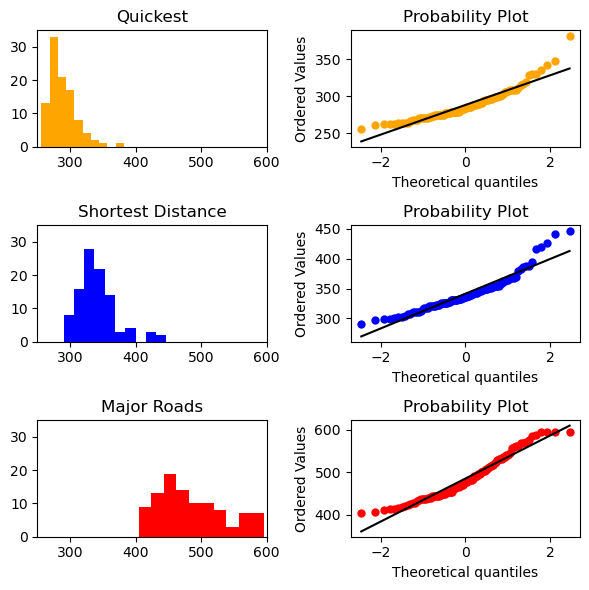

In [38]:
# plot distributions and qq plots

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2,  figsize=(6,6))
ax1.hist(quik_t_ct, color='orange')
ax1.set_title('Quickest')
ax1.set_ylim(0, 35)
ax1.set_xlim(250, 600)

stats.probplot(numpy.asarray(quik_t_ct), plot=ax2)
ax2.get_lines()[0].set_markerfacecolor('orange')
ax2.get_lines()[0].set_markeredgewidth(0)
ax2.get_lines()[1].set_color('black')

ax3.hist(dist_t_ct, color='blue')
ax3.set_title('Shortest Distance')
ax3.set_ylim(0, 35)
ax3.set_xlim(250, 600)

stats.probplot(numpy.asarray(dist_t_ct), plot=ax4)
ax4.get_lines()[0].set_markerfacecolor('blue')
ax4.get_lines()[0].set_markeredgewidth(0)
ax4.get_lines()[1].set_color('black')

ax5.hist(majr_t_ct, color='red')
ax5.set_title('Major Roads')
ax5.set_ylim(0, 35)
ax5.set_xlim(250, 600)

stats.probplot(numpy.asarray(majr_t_ct), plot=ax6)
ax6.get_lines()[0].set_markerfacecolor('red')
ax6.get_lines()[0].set_markeredgewidth(0)
ax6.get_lines()[1].set_color('black')

fig.tight_layout()

plt.savefig(os.path.join(out_folder, 'histograms and qq plots.eps'), format='eps')


This alpha value is used for the Shapiro-Wilk test of normality.

In [39]:
# set alpha value

alpha = 0.05


This calculates the Shapiro-Wilk test for the quickest treatment.

In [40]:
# Calculate Shapiro-Wilk test for normality

stat, p = stats.shapiro(quik_t_ct)
print('Quickest: Shapiro Statistics=%.3f, p=%.3f' % (stat, p))
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')


Quickest: Shapiro Statistics=0.894, p=0.000
Sample does not look Gaussian (reject H0)


This calculates the Shapiro-Wilk test for the shortest distance treatment.

In [41]:
# Calculate Shapiro-Wilk test for normality

stat, p = stats.shapiro(dist_t_ct)
print('Shortest Distance: Shapiro Statistics=%.3f, p=%.3f' % (stat, p))
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')


Shortest Distance: Shapiro Statistics=0.912, p=0.000
Sample does not look Gaussian (reject H0)


This calculates the Shapiro-Wilk test for the major roads treatment.

In [42]:
# Calculate Shapiro-Wilk test for normality

stat, p = stats.shapiro(majr_t_ct)
print('Major Roads: Shapiro Statistics=%.3f, p=%.3f' % (stat, p))
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')


Major Roads: Shapiro Statistics=0.947, p=0.001
Sample does not look Gaussian (reject H0)


This calculates the Friedman test for the treatments.

In [43]:
# Calculate Friedman Test to assess if repeated measues have the same distributions

stat, p = stats.friedmanchisquare(majr_t_ct, quik_t_ct, dist_t_ct)
print('Friedman Statistics=%.3f, p=%.3f' % (stat, p)) #df = k (num groups -1) = 3-1 = 2 (df = 2, n = 100)


Friedman Statistics=200.000, p=0.000


<a id='graph_clearance'></a>
## Graph clearance times
([back to Table of Contents](#top))

The code in this section creates a graph for clearance times. This first cell creates a boxplot.

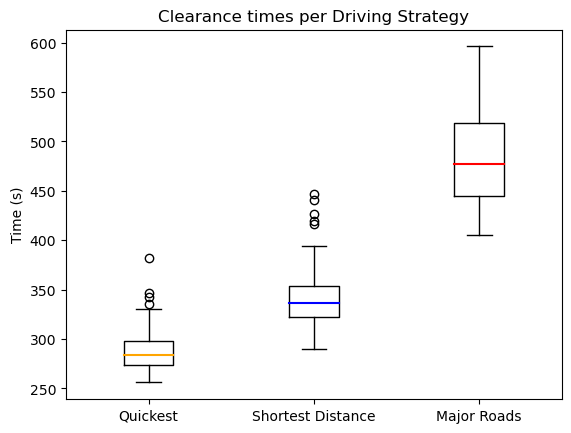

In [44]:
# Create clearance time boxplot

colors= ['orange', 'blue', 'red']

fig, ax = plt.subplots()
s = ax.boxplot((tot_clear_times['quik'], tot_clear_times['dist'], tot_clear_times['majr']))
for idx, median in enumerate(s['medians']):
    median.set(color=colors[idx], linewidth=1.5)
s = ax.set_xticklabels(('Quickest', 'Shortest Distance', 'Major Roads'))
s = ax.set_title('Clearance times per Driving Strategy')
s = ax.set_ylabel('Time (s)')

plt.savefig(os.path.join(out_folder,'clearance times per driving strategy.eps'), format='eps')


This graphs clearance time by seed for direct comparison.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


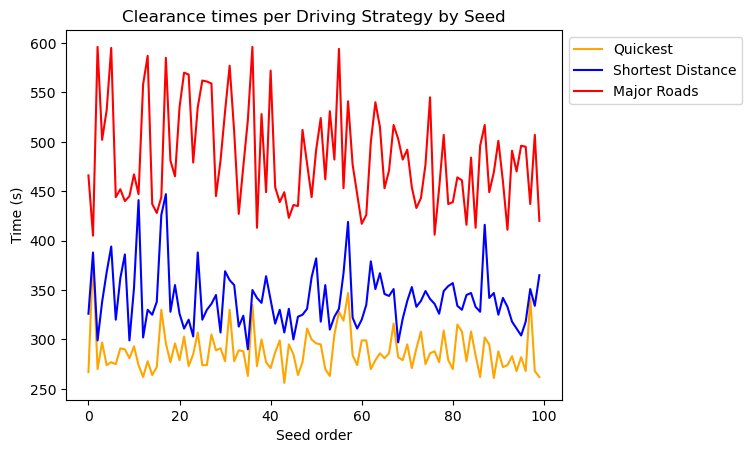

In [45]:
# Graph clearance times per driving strategy per seed

vid = ['_'+str(x) for x in range(0, 100)]
colorl = ['gray' for x in range(0, 100)]

data = {'vid':vid,
        'dist':dist_t_ct,
       'quik':quik_t_ct,
       'majr':majr_t_ct}

df = pd.DataFrame(data, columns=["vid","quik","dist","majr"])

s = df.plot(color=['orange','blue','red'])
s.legend(['Quickest', 'Shortest Distance', 'Major Roads'], bbox_to_anchor=(1, 1));
s.set_ylabel('Time (s)')
s.set_xlabel('Seed order')
plt.title('Clearance times per Driving Strategy by Seed');

plt.savefig(os.path.join(out_folder,'clearance times per driving strategy by seed.eps'), format='eps')


This graphs the precentage cleared.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


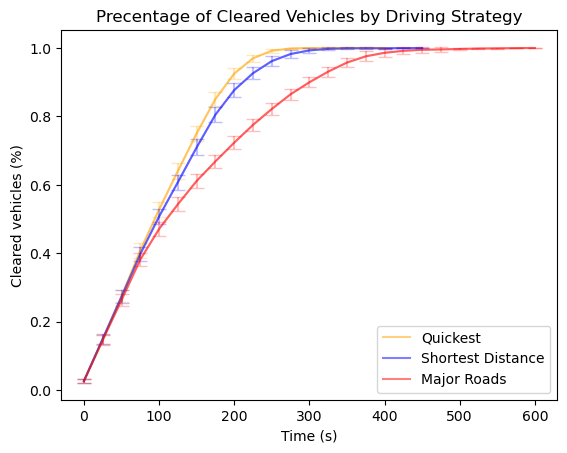

In [46]:
# Graph precent cleared by time chart

fig, ax = plt.subplots()

s = ax.plot(time_clear_lst_m_std_quik[0], time_clear_lst_m_std_quik[1], c='orange', alpha=0.5,  label='Quickest')
s = ax.errorbar(time_clear_lst_m_std_quik[0], time_clear_lst_m_std_quik[1], 
                time_clear_lst_m_std_quik[2], capsize=5, c='orange', alpha=0.25)

s = ax.plot(time_clear_lst_m_std_dist[0], time_clear_lst_m_std_dist[1], c='blue', alpha=0.5,  label='Shortest Distance')
s = ax.errorbar(time_clear_lst_m_std_dist[0], time_clear_lst_m_std_dist[1], 
                time_clear_lst_m_std_dist[2], capsize=5, c='blue', alpha=0.25)


s = ax.plot(time_clear_lst_m_std_majr[0], time_clear_lst_m_std_majr[1], c='red', alpha=0.5, label='Major Roads')
s = ax.errorbar(time_clear_lst_m_std_majr[0], time_clear_lst_m_std_majr[1], 
                time_clear_lst_m_std_majr[2], capsize=5, c='red', alpha=0.25)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Cleared vehicles (%)')
plt.title('Precentage of Cleared Vehicles by Driving Strategy')
s = ax.legend()

plt.savefig(os.path.join(out_folder,'percent clearance vehicles by time per driving strategy.eps'), format='eps')


<a id='graph_clearance_difference'></a>
## Graph clearance difference chart
([back to Table of Contents](#top))

In [47]:
# generate lists of same length to use for differences

dif_qu = len(time_clear_lst_m_std_majr[0])-len(time_clear_lst_m_std_quik[0])
dif_sh = len(time_clear_lst_m_std_majr[0])-len(time_clear_lst_m_std_dist[0])
pct_cl_x = time_clear_lst_m_std_majr[0] # x axis values
pct_cl_qu = time_clear_lst_m_std_quik[1] + [1.0 for x in range(dif_qu)]
pct_cl_sh = time_clear_lst_m_std_dist[1] + [1.0 for x in range(dif_sh)]
pct_cl_mr = time_clear_lst_m_std_majr[1]

In [48]:
# generate difference between percentage cleared

df_qu_sh = [(w-pct_cl_sh[i]) for i, w in enumerate(pct_cl_qu)]
df_qu_mr = [(w-pct_cl_mr[i]) for i, w in enumerate(pct_cl_qu)]
df_sh_mr = [(w-pct_cl_mr[i]) for i, w in enumerate(pct_cl_sh)]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


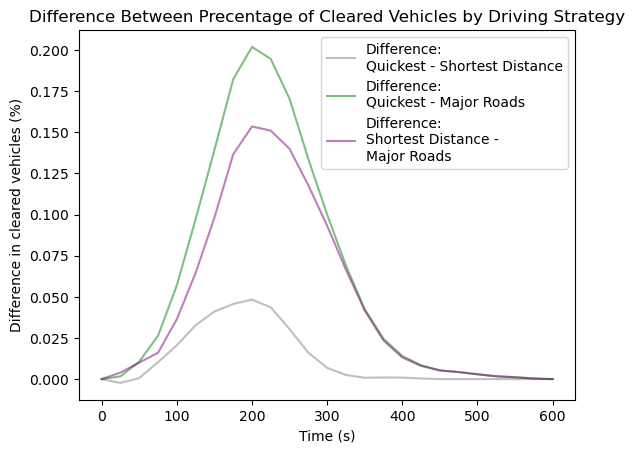

In [49]:
# Graph precent cleared by time chart

fig, ax = plt.subplots()

s = ax.plot(pct_cl_x, df_qu_sh, c='grey', alpha=0.5,  label='Difference:\nQuickest - Shortest Distance')

s = ax.plot(pct_cl_x, df_qu_mr, c='green', alpha=0.5,  label='Difference:\nQuickest - Major Roads')

s = ax.plot(pct_cl_x, df_sh_mr, c='purple', alpha=0.5,  label='Difference:\nShortest Distance -\nMajor Roads')



ax.set_xlabel('Time (s)')
ax.set_ylabel('Difference in cleared vehicles (%)')
plt.title('Difference Between Precentage of Cleared Vehicles by Driving Strategy')
s = ax.legend()

plt.savefig(os.path.join(out_folder,'difference betwwen percent clearance vehicles by time per driving strategy.eps'),  format='eps')

<a id='graph_congestion'></a>
## Graph congestion chart
([back to Table of Contents](#top))

This creates a graph of congestion.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


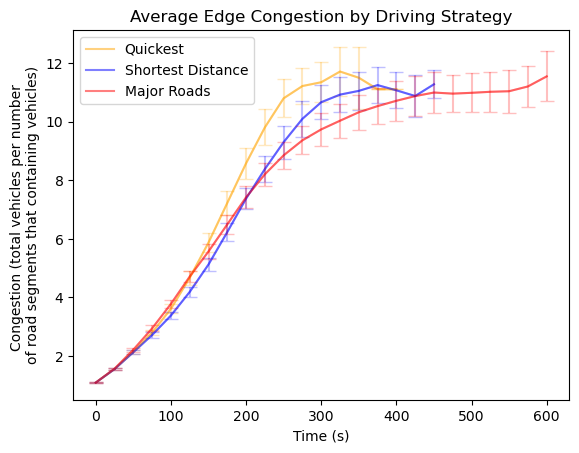

In [50]:
# Congstion by time chart

fig, ax = plt.subplots()

s = ax.plot(time_cong_lst_m_std_quik[0], time_cong_lst_m_std_quik[1], c='orange', alpha=0.5,  label='Quickest')
s = ax.errorbar(time_cong_lst_m_std_quik[0], time_cong_lst_m_std_quik[1], 
                time_cong_lst_m_std_quik[2], capsize=5, c='orange', alpha=0.25)

s = ax.plot(time_cong_lst_m_std_dist[0], time_cong_lst_m_std_dist[1], c='blue', alpha=0.5,  label='Shortest Distance')
s = ax.errorbar(time_cong_lst_m_std_dist[0], time_cong_lst_m_std_dist[1], 
                time_cong_lst_m_std_dist[2], capsize=5, c='blue', alpha=0.25)

s = ax.plot(time_cong_lst_m_std_majr[0], time_cong_lst_m_std_majr[1], c='red', alpha=0.5, label='Major Roads')
s = ax.errorbar(time_cong_lst_m_std_majr[0], time_cong_lst_m_std_majr[1], 
                time_cong_lst_m_std_majr[2], capsize=5, c='red', alpha=0.25)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Congestion (total vehicles per number \nof road segments that containing vehicles)')
plt.title('Average Edge Congestion by Driving Strategy')
s = ax.legend()
plt.savefig(os.path.join(out_folder,'average edge congestion by time per driving strategy.eps'), format='eps')


<a id='graph_congestion_difference'></a>
## Graph congestion difference chart
([back to Table of Contents](#top))

In [51]:
# generate lists of same length to use for differences

pct_cong_qu = time_cong_lst_m_std_quik[1] + [1.0 for x in range(dif_qu)]
pct_cong_sh = time_cong_lst_m_std_dist[1] + [1.0 for x in range(dif_sh)]
pct_cong_mr = time_cong_lst_m_std_majr[1]

In [52]:
# generate difference between percentage cleared

df_cong_qu_sh = [(w-pct_cong_sh[i]) for i, w in enumerate(pct_cong_qu)]
df_cong_qu_mr = [(w-pct_cong_mr[i]) for i, w in enumerate(pct_cong_qu)]
df_cong_sh_mr = [(w-pct_cong_mr[i]) for i, w in enumerate(pct_cong_sh)]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


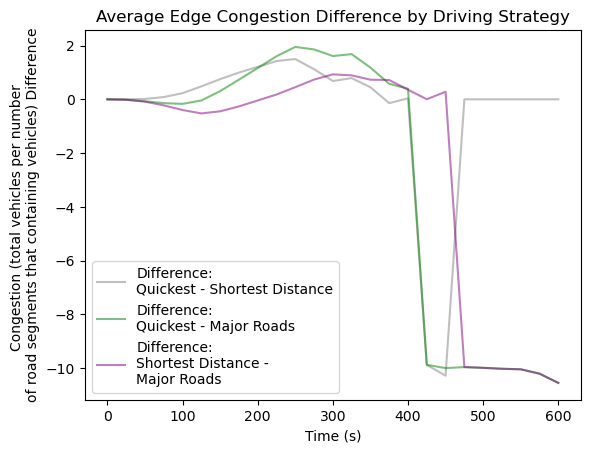

In [53]:
# Congstion by time chart

fig, ax = plt.subplots()

s = ax.plot(pct_cl_x, df_cong_qu_sh, c='grey', alpha=0.5,  label='Difference:\nQuickest - Shortest Distance')

s = ax.plot(pct_cl_x, df_cong_qu_mr, c='green', alpha=0.5,  label='Difference:\nQuickest - Major Roads')

s = ax.plot(pct_cl_x, df_cong_sh_mr, c='purple', alpha=0.5, label='Difference:\nShortest Distance -\nMajor Roads')


ax.set_xlabel('Time (s)')
ax.set_ylabel('Congestion (total vehicles per number \nof road segments that containing vehicles) Difference')
plt.title('Average Edge Congestion Difference by Driving Strategy')
s = ax.legend()
plt.savefig(os.path.join(out_folder,'average edge congestion difference by time per driving strategy.eps'), format='eps')